## Data Setup


In [1]:
import dataset
import utils
import reference_impl as ref
import model
import simulator as sim

# Use this cfg variable whenever we need to access some constant
cfg = utils.Config(
    num_rx_antennas=1,
    num_tx_antennas=64,
    num_subcarriers=160,
    train_test_split=0.8,
    data_root="../data/dataset1",
    # duplicate_data=1,
    # data_snr=-1
)

train_set, test_set = dataset.load_data(cfg)

## Offline Training


In [2]:
import matlab.engine
matlab = matlab.engine.start_matlab()

In [3]:
pca = ref.ReferencePCA(cfg, matlab)
model.train_or_load(pca, cfg.pca_path, cfg.retrain_all, train_set.csi_samples)  # pca.fit() includes reduce overhead

Reducing offloading overhead...


In [4]:
zdl_train = pca.process(train_set.csi_samples)                # N * zdl_len

windows_shape = train_set.csi_windows.shape                   # N * window_size * na * nc
zdl_train_windows = train_set.csi_windows.reshape(            # (N * window_size) * na * nc
    -1, windows_shape[2], windows_shape[3]
)
zdl_train_windows = pca.process(zdl_train_windows)
zdl_train_windows = zdl_train_windows.reshape(
    windows_shape[0], windows_shape[1], zdl_train.shape[1]
)  # N * window_size * zdl_len

In [5]:
## Train Predictor
predictor = ref.NullPredictor()                               # With NullPredictor, prediction_error is just zDL! This lets us test the ref impl
model.train_or_load(predictor, cfg.predictor_path, cfg.retrain_all, zdl_train, zdl_train_windows)
predicted_zdl = predictor.process(zdl_train_windows)

prediction_error = zdl_train - predicted_zdl

In [6]:
## Error Compression
error_compressor = ref.ReferenceKmeans(cfg, matlab)
model.train_or_load(error_compressor, cfg.kmeans_path, cfg.retrain_all, prediction_error)

# DL and UL each get trained pca, predictor, and error_compressor

Training k-means clustering...
Considering bTot: 100
Considering bTot: 200
Considering bTot: 300
Considering bTot: 400
Considering bTot: 500
Considering bTot: 600
Considering bTot: 700
Considering bTot: 800
Considering bTot: 900
Considering bTot: 1000
Considering bTot: 1100
Considering bTot: 1200


  0%|          | 0/9 [00:00<?, ?it/s]

## Visualize?


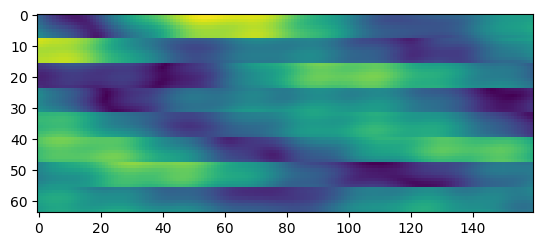

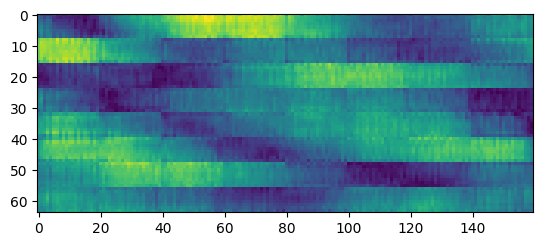

In [7]:
# Verify PCA is working!

import numpy as np
import matplotlib.pyplot as plt
ori = np.expand_dims(test_set[1].csi, axis=0)
plt.imshow(np.squeeze(np.abs(ori)))
plt.figure()

single_zdl = pca.process(ori)
recovered = pca.decode(single_zdl)
plt.imshow(np.squeeze(np.abs(recovered)))

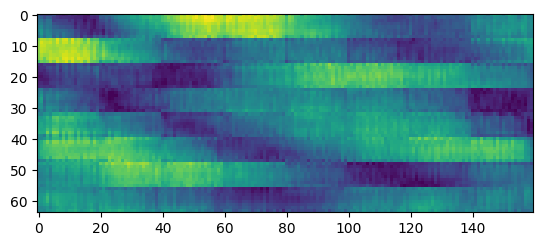

In [8]:
# Kmeans is also working!
quantized_zdl = error_compressor.process(single_zdl)
padded_zdl = error_compressor.decode(quantized_zdl)
quantized_recovered = pca.decode(padded_zdl)
plt.imshow(np.squeeze(np.abs(quantized_recovered)))

# Testing

In [9]:
## Downlink


# ZDLs for test set
zdl_test = pca.process(test_set.csi_samples)  # N * zdl_len
windows_shape = test_set.csi_windows.shape  # N * window_size * na * nc
zdl_test_windows = test_set.csi_windows.reshape(  # (N * window_size) * na * nc
    -1, windows_shape[2], windows_shape[3]
)
zdl_test_windows = pca.process(zdl_test_windows)
zdl_test_windows = zdl_test_windows.reshape(
    windows_shape[0], windows_shape[1], zdl_test.shape[1]
)  # N * window_size * zdl_len

# Predictions for Test Set
predicted_zdl_test = predictor.process(zdl_test_windows)  
# TODO: Passing Test windows directly is a simplification and may not reflect performance in sequential test
prediction_error_test = zdl_test - predicted_zdl_test

# Compression
compressed_error_test = error_compressor.process(prediction_error_test)

## Uplink
ul_pred_error = error_compressor.decode(compressed_error_test)
ul_pred_zdl = predictor.process(zdl_test_windows)
ul_reconst_zdl = ul_pred_error + ul_pred_zdl
ul_pred_csi = pca.decode(ul_reconst_zdl)

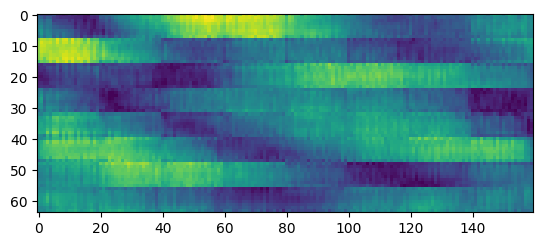

In [10]:
plt.imshow(np.abs(ul_pred_csi[1]))

Assessing performance...
Plotting results...


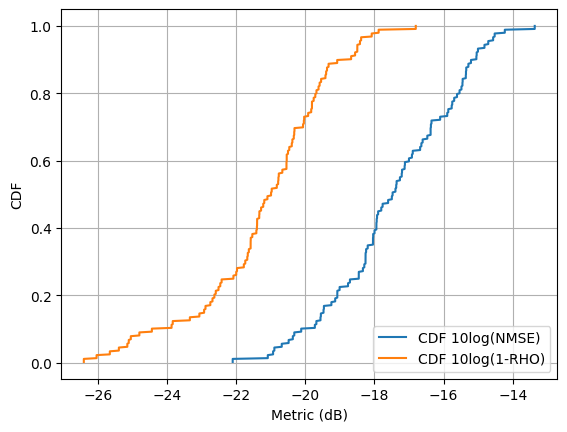

In [11]:

# Assessing performance
print("Assessing performance...")

nmse = np.zeros(len(test_set))
rho = np.zeros(len(test_set))

for i in range(len(test_set)):
    ch = test_set[i].csi
    ch_h = ul_pred_csi[i]
    nmse[i] = utils.func_nmse(ch_h, ch)  # Assumes func_nmse is defined
    rho[i] = utils.func_rho(ch_h, ch)    # Assumes func_rho is defined

# Plotting results
print("Plotting results...")
LineW = 1.5

plt.figure()
cdf_nmse = np.sort(10 * np.log10(nmse))
cdf_rho = np.sort(10 * np.log10(1 - rho))

probabilities = np.arange(1, len(cdf_nmse) + 1) / len(cdf_nmse)

plt.plot(cdf_nmse, probabilities, label='CDF 10log(NMSE)', linewidth=LineW)
plt.plot(cdf_rho, probabilities, label='CDF 10log(1-RHO)', linewidth=LineW)

# plt.xlim([-22, 0])
# plt.xticks(range(-22, 1, 2))
plt.xlabel('Metric (dB)')
plt.ylabel('CDF')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Simulation
- "End to End" Simulation
- Show simulation of entire new "test" path made up of portions of paths that were trained on

In [ ]:
# Load in pretrained components
dl_sim: sim.DLSimulator = sim.DLSimple(cfg, pca, predictor, error_compressor)
ul_sim: sim.ULSimulator = sim.ULSimple(cfg, pca, predictor, error_compressor)

evaluator = sim.Evaluator()

for sample in test_set:
    quantized_error = dl_sim.simulate(sample)
    # Send quantized_error over CHANNEL
    predicted_csi = ul_sim.simulate(quantized_error)
    evaluator.evaluate(sample, predicted_csi)
    
evaluator.report()
evaluator.visualize()

In [15]:
"""
Run this cell to reload all modules

When making changes to classes in Python files, either restarting the kernel or reloading modules is necessary
In order to support reloading modules, use
    import mymodule
or
    import mymodule as m
syntax for our own modules, instead of 'from mymodule import thing'
"""

import importlib
importlib.reload(utils)
importlib.reload(dataset)
importlib.reload(model)
importlib.reload(sim)
importlib.reload(ref)

<module 'reference_impl' from '/Users/dziper/UCSD/F24/ECE 257A/NonstaticCSI/project/reference_impl.py'>